<a href="https://colab.research.google.com/github/felipedefacio/devtraining-needit-london/blob/master/RL_kNN_MovAv_AutoA_Prophet_LSTM_AIGSeguros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install fastai==0.7.0 


     |████████████████████████████████| 122kB 4.9MB/s 
     |████████████████████████████████| 1.5MB 45.7MB/s 
     |████████████████████████████████| 496.4MB 35kB/s 
  Created wheel for bcolz: filename=bcolz-1.2.1-cp36-cp36m-linux_x86_64.whl size=2661698 sha256=d74f1bde6cd0c009e8c31f553d29bb64d0be9ee98803d0941f49eafe759b0f5e
  Stored in directory: /root/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
Successfully built bcolz
ERROR: torchvision 0.4.1+cu100 has requirement torch==1.3.0, but you'll have torch 0.3.1 which is incompatible.
  Found existing installation: torch 1.3.0+cu100
    Uninstalling torch-1.3.0+cu100:
      Successfully uninstalled torch-1.3.0+cu100
  Found existing installation: fastai 1.0.59
    Uninstalling fastai-1.0.59:
      Successfully uninstalled fastai-1.0.59


In [0]:
pip install pyramid-arima

     |████████████████████████████████| 604kB 4.9MB/s 


In [0]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


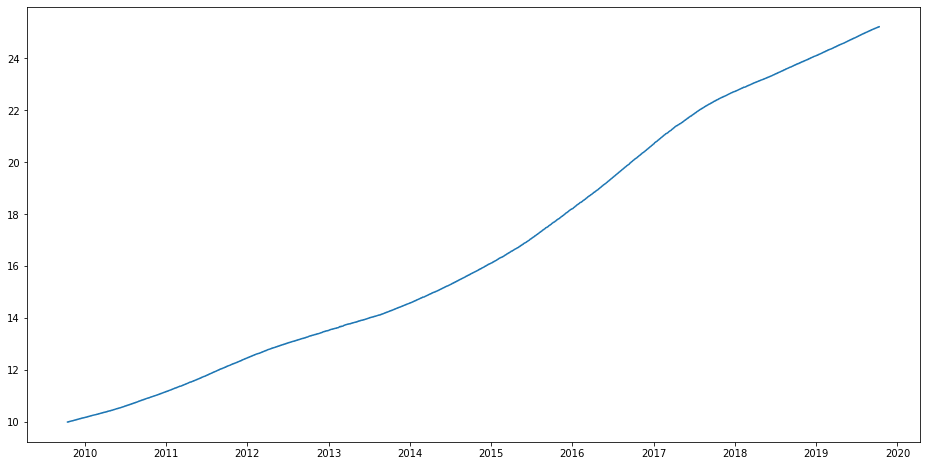

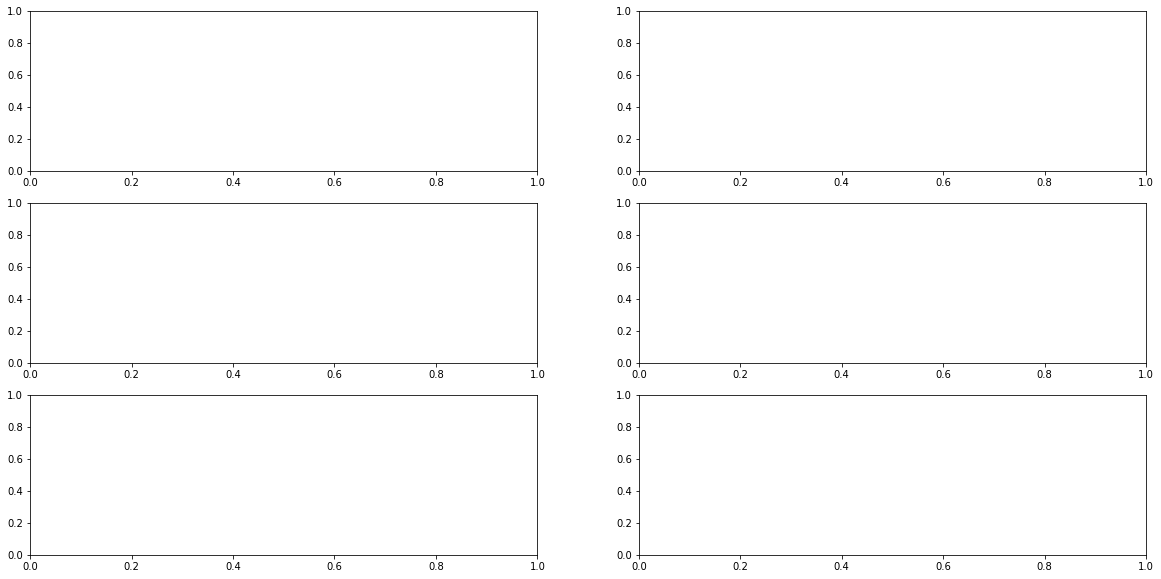

In [0]:
#importando bibliotecas
import pandas as pd
import numpy as np

#biblioteca para plotagem
import matplotlib.pyplot as plt
# %matplotlib inline

#ajustando tamanho da figura
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#função para normalizar dados
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#leitura do arquivo
df = pd.read_csv('drive/My Drive/Mackenzie/TCC/Projeto/Bases de dados/AIG SEGUROS FUNDO DE INVESTIMENTO.csv', encoding='latin-1', delimiter = ";")
df.columns = ['Código', 'Fundo', 'Data','Fechamento', 'Var. Dia(%)', 'Capitacao', 'Resgate', 'PL', 'Cotistas']
df['Data'] = pd.to_datetime(df.Data,format='%d/%m/%Y')
df.index = df['Data']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Fechamento'], label='Preço de Fechamento Histórico')

# iniciando o subplot
fig, axs = plt.subplots(3, 2)

#ordenando
data = df.sort_index(ascending=True, axis=0)

In [0]:
#Bloco Média Móvel

#criação de um dataset separado
target_data_1 = pd.DataFrame(index=range(0,len(df)),columns=['Data', 'Fechamento_1'])
for i in range(0,len(data)):
    target_data_1['Data'][i] = data['Data'][i]
    target_data_1['Fechamento_1'][i] = data['Fechamento'][i]

#definindo o índice
target_data_1.index = target_data_1.Data

                           
# divisão dos dados entre treino e validação
train_1 = target_data_1[:2006]
valid_1 = target_data_1[2006:]

# In the next step, we will create predictions for the validation set and check the RMSE using the actual values.
# making predictions
preds_1 = []
for i in range(0,valid_1.shape[0]):
    a = train_1['Fechamento_1'][len(train_1)-502+i:].sum() + sum(preds_1)
    b = a/502
    preds_1.append(b)

#plot
valid_1['Predictions_1'] = 0
valid_1['Predictions_1'] = preds_1
axs[0, 0].plot(train_1['Fechamento_1'])
axs[0, 0].plot(valid_1[['Fechamento_1', 'Predictions_1']])
axs[0, 0].set_title('Média móvel')
axs[0, 0].set(xlabel='Ano')

    
# checking the results (RMSE value)
rms_MovAv=np.sqrt(np.mean(np.power((np.array(valid_1['Fechamento_1'])-preds_1),2)))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [0]:
rms_MovAv

3.07667522940883

In [0]:
#Bloco Regressão Linear

#criação de um dataset separado
target_data_2 = pd.DataFrame(index=range(0,len(df)),columns=['Data', 'Fechamento_2'])
for i in range(0,len(data)):
    target_data_2['Data'][i] = data['Data'][i]
    target_data_2['Fechamento_2'][i] = data['Fechamento'][i]

#setting index
target_data_2.index = target_data_2.Data

#create features
from fastai.structured import  add_datepart
add_datepart(target_data_2, 'Data')
target_data_2.drop('DataElapsed', axis=1, inplace=True)  #elapsed will be the time stamp

#criação de feature (Segunda-Sexta)
target_data_2['mon_fri'] = 0
for i in range(0,len(target_data_2)):
    if (target_data_2['DataDayofweek'][i] == 0 or target_data_2['DataDayofweek'][i] == 4):
        target_data_2['mon_fri'][i] = 1
    else:
        target_data_2['mon_fri'][i] = 0

        
#split into train and validation
train_2 = target_data_2[:2006]
valid_2 = target_data_2[2006:]
x_train_2 = train_2.drop('Fechamento_2', axis=1)
y_train_2 = train_2['Fechamento_2']
x_valid_2 = valid_2.drop('Fechamento_2', axis=1)
y_valid_2 = valid_2['Fechamento_2']


#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train_2,y_train_2)

#make predictions and find the rmse
preds_2 = model.predict(x_valid_2)
rms_RL=np.sqrt(np.mean(np.power((np.array(y_valid_2)-np.array(preds_2)),2)))

# ajuste de plot
valid_2['Predictions_2'] = 0
valid_2['Predictions_2'] = preds_2
valid_2.index = target_data_2[2006:].index
train_2.index = target_data_2[:2006].index


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.

In [0]:
rms_RL

1.2559027709888404

In [0]:
#Bloco k-NN

#importing libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV

#criação de um dataset separado
target_data_3 = pd.DataFrame(index=range(0,len(df)),columns=['Data', 'Fechamento_3'])
for i in range(0,len(data)):
    target_data_3['Data'][i] = data['Data'][i]
    target_data_3['Fechamento_3'][i] = data['Fechamento'][i]

#setting index
target_data_3.index = target_data_3.Data

#create features
from fastai.structured import  add_datepart
add_datepart(target_data_3, 'Data')
target_data_3.drop('DataElapsed', axis=1, inplace=True)  #elapsed will be the time stamp

#criação de feature (Segunda-Sexta)
target_data_3['mon_fri'] = 0
for i in range(0,len(target_data_3)):
    if (target_data_3['DataDayofweek'][i] == 0 or target_data_3['DataDayofweek'][i] == 4):
        target_data_3['mon_fri'][i] = 1
    else:
        target_data_3['mon_fri'][i] = 0

        
#split into train and validation
train_3 = target_data_3[:2006]
valid_3 = target_data_3[2006:]
x_train_3 = train_3.drop('Fechamento_3', axis=1)
y_train_3 = train_3['Fechamento_3']
x_valid_3 = valid_3.drop('Fechamento_3', axis=1)
y_valid_3 = valid_3['Fechamento_3']


#scaling data
x_train_scaled_3 = scaler.fit_transform(x_train_3)
x_train_3 = pd.DataFrame(x_train_scaled_3)
x_valid_scaled_3 = scaler.fit_transform(x_valid_3)
x_valid_3 = pd.DataFrame(x_valid_scaled_3)

#busca o melhor parâmetro k
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#ajusta o modelo e faz predições
model.fit(x_train_3,y_train_3)
preds_3 = model.predict(x_valid_3)

#rmse
rms_Knn=np.sqrt(np.mean(np.power((np.array(y_valid_3)-np.array(preds_3)),2)))

#plot
valid_3['Predictions_3'] = 0
valid_3['Predictions_3'] = preds_3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to b

In [0]:
rms_Knn

8.375954206210883

In [0]:
#Bloco Auto Arima

from pyramid.arima import auto_arima

data = df.sort_index(ascending=True, axis=0)

train_4 = data[:2006]
valid_4 = data[2006:]

training = train_4['Fechamento']
validation = valid_4['Fechamento']

model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

forecast = model.predict(n_periods=502)
forecast = pd.DataFrame(forecast,index = valid_4.index,columns=['Prediction_4'])

#erro rms
rms_AutoA=np.sqrt(np.mean(np.power((np.array(valid_4['Fechamento'])-np.array(forecast['Prediction_4'])),2)))


#plot
#plt.plot(train['Fechamento'])
#plt.plot(valid['Fechamento'])
#plt.plot(forecast['Prediction'])

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/pyramid/__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a pac

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-16798.311, BIC=-16770.325, Fit time=27.743 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=-14660.154, BIC=-14648.959, Fit time=1.103 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=-16319.133, BIC=-16296.743, Fit time=6.414 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-16475.270, BIC=-16452.880, Fit time=21.522 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=-16580.063, BIC=-16546.478, Fit time=33.315 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=-15788.106, BIC=-15765.716, Fit time=4.386 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-16817.635, BIC=-16784.050, Fit time=58.705 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-16378.302, BIC=-16350.315, Fit time=29.623 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-16823.382, BIC=-16784.200, Fit time=5

In [0]:
rms_AutoA

0.6963934981516495

In [0]:
#Bloco Prophet

#importando prophet
from fbprophet import Prophet

#criação do dataframe
target_data_5 = pd.DataFrame(index=range(0,len(df)),columns=['Data', 'Fechamento_5'])

for i in range(0,len(data)):
    target_data_5['Data'][i] = data['Data'][i]
    target_data_5['Fechamento_5'][i] = data['Fechamento'][i]
    
target_data_5['Data'] = pd.to_datetime(target_data_5.Data,format='%Y-%m-%d')
target_data_5.index = target_data_5['Data']

#preparando os dados
target_data_5.rename(columns={'Fechamento_5': 'y', 'Data': 'ds'}, inplace=True)

#train and validation
train_5 = target_data_5[:2006]
valid_5 = target_data_5[2006:]

#ajusta o modelo
model = Prophet()
model.fit(train_5)

#predictions
valores_fechamento = model.make_future_dataframe(periods=len(valid_5))
previsao = model.predict(valores_fechamento)
 
#rmse
previsao_validacao = previsao['yhat'][2006:]
rms_proph=np.sqrt(np.mean(np.power((np.array(valid_5['y'])-np.array(previsao_validacao)),2)))

  
#plot
valid_5['Predictions_5'] = 0
valid_5['Predictions_5'] = previsao_validacao.values

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [0]:
rms_proph

0.4538115362308003

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



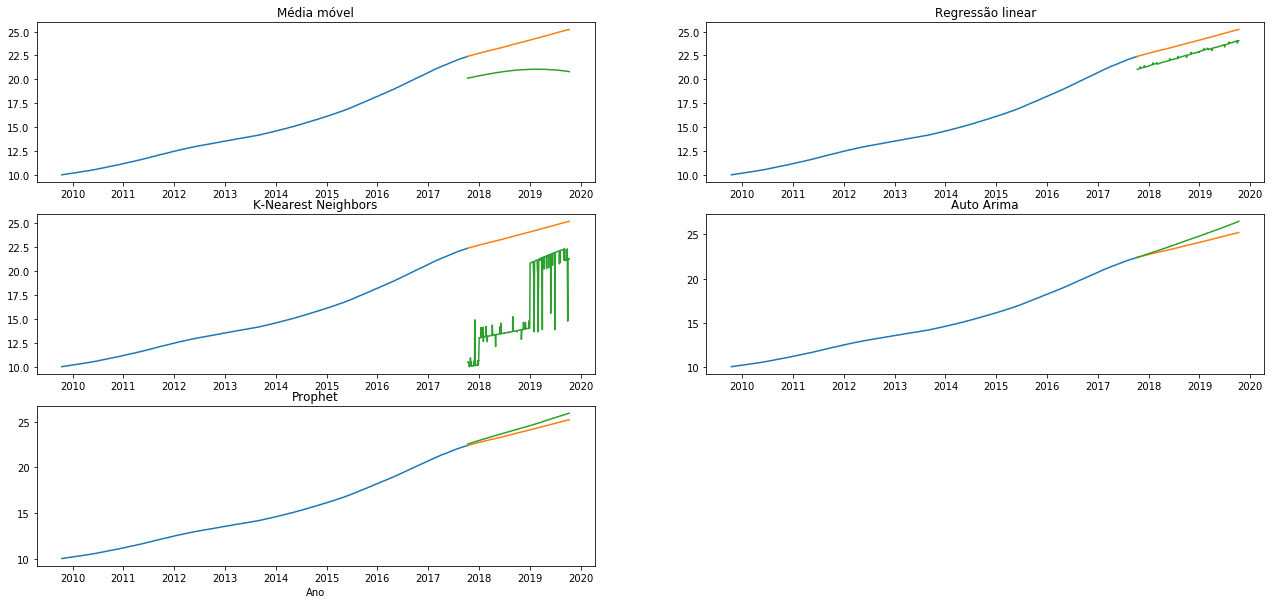

In [0]:
#Bloco plotagem
fig, axs = plt.subplots(3, 2, figsize=(22,10))

#Média Móvel
valid_1['Predictions_1'] = 0
valid_1['Predictions_1'] = preds_1
axs[0, 0].plot(train_1['Fechamento_1'])
axs[0, 0].plot(valid_1[['Fechamento_1', 'Predictions_1']])
axs[0, 0].set_title('Média móvel')

#Regressão Linear
axs[0, 1].plot(train_2['Fechamento_2'])
axs[0, 1].plot(valid_2[['Fechamento_2', 'Predictions_2']])
axs[0, 1].set_title('Regressão linear')

#k-NN
axs[1, 0].plot(train_3['Fechamento_3'])
axs[1, 0].plot(valid_3[['Fechamento_3', 'Predictions_3']])
axs[1, 0].set_title('K-Nearest Neighbors')

#Auto Arima
axs[1, 1].plot(train_4['Fechamento'])
axs[1, 1].plot(valid_4['Fechamento'])
axs[1, 1].plot(forecast['Prediction_4'])
axs[1, 1].set_title('Auto Arima')

#Prophet
axs[2, 0].plot(train_5['y'])
axs[2, 0].plot(valid_5[['y', 'Predictions_5']])
axs[2, 0].set_title('Prophet')
axs[2, 0].set(xlabel='Ano')

fig.delaxes(axs[2,1])